# Поиск по изображениям

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Загрузка данных

In [ ]:
!pip install optuna -q
!pip install optuna-integration -q
!pip install catboost -q
!pip install torchmetrics -q

# !pip uninstall -y tensorflow -q
# !pip install tensorflow-cpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import random
import requests
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor

import torch
import torch.nn as nn
from torchmetrics import MeanSquaredError
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from transformers import BertTokenizer, BertModel


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import optuna
from optuna import trial
from optuna import distributions
from optuna.integration import OptunaSearchCV

from catboost import CatBoostRegressor

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

In [ ]:
DATA_PATH = '/content/to_upload'

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Директории с изображениями

Первые 5 изображений находящихся в директориях:

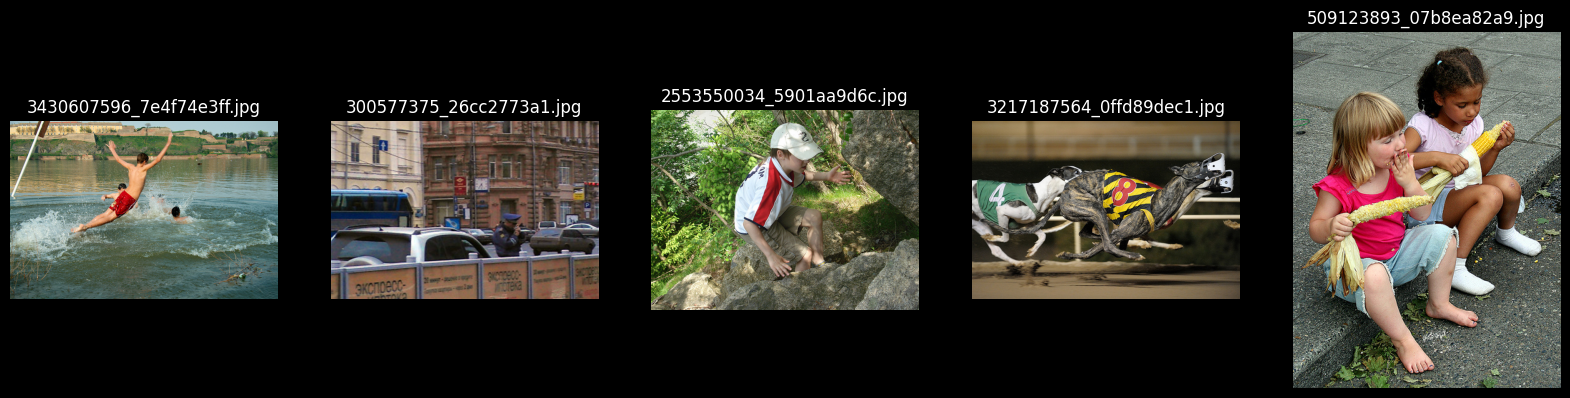

Количество файлов в директории: 1000


In [ ]:
directory = os.path.join(DATA_PATH, 'train_images')
files = os.listdir(directory)

fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i, file in enumerate(files[:5]):
    img_path = os.path.join(directory, file)
    img = plt.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')
plt.show()

print("Количество файлов в директории:", len(files))

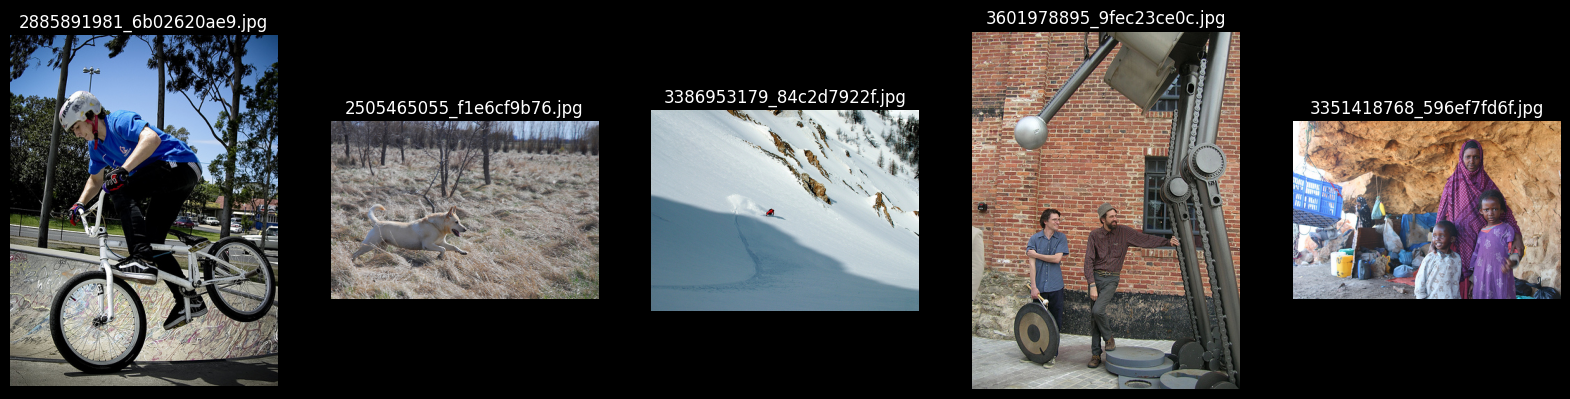

Количество файлов в директории: 101


In [ ]:
directory = os.path.join(DATA_PATH, 'test_images')
files = os.listdir(directory)

fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i, file in enumerate(files[:5]):
    img_path = os.path.join(directory, file)
    img = plt.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')
plt.show()

print("Количество файлов в директории:", len(files))

Фотографии находящиеся в директории выглядят +- корректно, у некоторых чуть меньший формат. Присутствуют изображения с несовершеннолетними

### train_dataset

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))
train_df.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [ ]:
train_df

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A young child is wearing blue goggles and sitt...  
2     A young child is wearing blue goggles and sitt...  
3     A young child is wearing blue goggles and sitt...  
4     A young child is wearing blue goggles and sitt...  
...                                                 ...  
5817         A man in an ampitheater talking to a boy .  
5818          a old man walks down the uncrowded road .  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .  

[5822 rows x 3 columns]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [ ]:
train_df.isna().mean()

image         0.0
query_id      0.0
query_text    0.0
dtype: float64

In [ ]:
train_df.duplicated().sum()

0

Таблица train_df представляет тренировочную выборку в которой соответствие названия .jpg файла 'image' c фразой  в колонке 'query_text'. Всего 5822 наблюдения, пропусков и явных дубликатов нет

### CrowdAnnotations

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

Имя файла изображения.
Идентификатор описания.
Доля людей, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание не соответствует изображению.


In [ ]:
CrowdAnnotations = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t', header=None)

CrowdAnnotations.head()

0                            1    2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0  0  3
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0  0  3
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0  0  3

In [ ]:
CrowdAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [ ]:
CrowdAnnotations.isna().mean()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [ ]:
CrowdAnnotations.duplicated().sum()

0

In [ ]:
CrowdAnnotations[2].unique()

array([1.        , 0.        , 0.33333333, 0.66666667, 0.25      ,
       0.6       , 0.2       , 0.5       , 0.4       , 0.75      ,
       0.16666667, 0.8       ])

In [ ]:
CrowdAnnotations[3].unique()

array([3, 0, 1, 2, 4, 5])

In [ ]:
CrowdAnnotations[4].unique()

array([0, 3, 2, 1, 4, 5, 6])

In [ ]:
len(CrowdAnnotations[0].unique())

1000

In [ ]:
len(CrowdAnnotations[1].unique())

1000

In [ ]:
len(train_df['query_id'].unique())

977

CrowdAnnotations имеет ценность оценки соответствия с краудсорсинга для различных изображений со фразами. Всего 47830 наблюдений, пропусков и явных дубликатов нет

### ExpertAnnotations

В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

Имя файла изображения.
Идентификатор описания.
3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

In [ ]:
ExpertAnnotations = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t', header=None)

ExpertAnnotations.head()

0                            1  2  3  4
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2

In [ ]:
ExpertAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [ ]:
ExpertAnnotations

0                            1  2  3  4
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2
...                         ...                          ... .. .. ..
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2  1  1  1
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2  1  1  1
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2  1  1  2
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2  1  1  1
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2  3  3  3

[5822 rows x 5 columns]

In [ ]:
ExpertAnnotations.isna().mean()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [ ]:
ExpertAnnotations.duplicated().sum()

0

In [ ]:
ExpertAnnotations[2].unique()

array([1, 2, 3, 4])

In [ ]:
ExpertAnnotations[3].unique()

array([1, 2, 3, 4])

In [ ]:
ExpertAnnotations[4].unique()

array([1, 2, 3, 4])

Объединим оценку 3 экспертов в общую посчитав среднее между ними

In [ ]:
ExpertAnnotations[[2, 3, 4]] = ExpertAnnotations[[2, 3, 4]].apply(pd.to_numeric)
ExpertAnnotations['general_rating'] = (ExpertAnnotations[[2, 3, 4]].sum(axis=1) / 3)
ExpertAnnotations.head()

0                            1  2  3  4  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2   

   general_rating  
0        1.000000  
1        1.333333  
2        1.333333  
3        1.666667  
4        1.333333

В ExpertAnnotations представленна оценнка 3 экспертов для данных из тренировочной выборки, оценка экспертов объединена в колонке 'general_rating'. Всего 5822 наблюдения, пропусков и явных дубликатов нет

### test_queries

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

In [ ]:
test_queries = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), sep='|', index_col=0)

test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [ ]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [ ]:
test_queries.isna().mean()

query_id      0.0
query_text    0.0
image         0.0
dtype: float64

In [ ]:
test_queries.duplicated().sum()

0

test_queries данные для тестирования с изображениями и описанием. 500 семплов, пропусков и явных дубликатов нет

### test_images

In [ ]:
test_images = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'), sep='|', index_col=0)

test_images.head()

Empty DataFrame
Columns: []
Index: [3356748019_2251399314.jpg, 2887171449_f54a2b9f39.jpg, 3089107423_81a24eaf18.jpg, 1429546659_44cb09cbe2.jpg, 1177994172_10d143cb8d.jpg]

In [ ]:
test_images.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 3356748019_2251399314.jpg to 2346402952_e47d0065b6.jpg
Empty DataFrame


In [ ]:
test_images.isna().mean()

Series([], dtype: float64)

In [ ]:
test_images.duplicated().sum()

0

test_images колонка с именами .jpg файлов. 100 семплов, пропусков и явных дубликатов нет

### Общий вывод по EDA:

-Фотографии находящиеся в директории выглядят +- корректно, у некоторых чуть меньший формат. Присутствуют изображения с несовершеннолетними

-Таблица train_df представляет тренировочную выборку в которой соответствие названия .jpg файла 'image' c фразой  в колонке 'query_text'. Всего 5822 наблюдения, пропусков и явных дубликатов нет

-CrowdAnnotations имеет ценность оценки соответствия с краудсорсинга для различных изображений со фразами. Всего 47830 наблюдений, пропусков и явных дубликатов нет

-В ExpertAnnotations представленна оценнка 3 экспертов для данных из тренировочной выборки, оценка экспертов объединена в колонке 'general_rating'. Всего 5822 наблюдения, пропусков и явных дубликатов нет

-test_queries данные для тестирования с изображениями и описанием. 500 семплов, пропусков и явных дубликатов нет

-test_images колонка с именами .jpg файлов. 100 семплов, пропусков и явных дубликатов нет

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


Создание функции и проверка описаний изображений в тренировочной выборке по запрещенным словам-триггерам отсылающих на детей до 16 лет

In [ ]:
def exclude_images_with_children1(df):

    children_keywords = ['child', 'children', 'kid', 'kids', 'teen', 'teenager',
                         'minor', 'juvenile', 'young', 'youth', 'baby', 'boy']
    mask = ~df['query_text'].str.contains('|'.join(children_keywords), case=False, na=False)
    df_filtered = df[mask]

    return df_filtered

train_df_filtered1 = exclude_images_with_children1(train_df)
train_df_filtered1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4562 entries, 12 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4562 non-null   object
 1   query_id    4562 non-null   object
 2   query_text  4562 non-null   object
dtypes: object(3)
memory usage: 142.6+ KB


In [ ]:
len(train_df_filtered1['image'].unique())

1000

In [ ]:
def exclude_images_with_children(df_train, df_expert):
    children_keywords = ['child', 'children', 'kid', 'kids', 'teen', 'teenager',
                         'minor', 'juvenile', 'young', 'youth', 'baby', 'boy']

    merged_df = df_train.join(df_expert.set_index(0), on='image', how='left')

    rating_filter = merged_df['general_rating'] > 2
    children_filter = merged_df['query_text'].str.contains('|'.join(children_keywords), case=False, na=False)

    final_filter = rating_filter & children_filter

    df_filtered = merged_df[final_filter]

    return df_filtered[['image', 'query_id', 'query_text']].drop_duplicates()

train_df_not_filtered = exclude_images_with_children(train_df, ExpertAnnotations)
train_df_not_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 1 to 5817
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       700 non-null    object
 1   query_id    700 non-null    object
 2   query_text  700 non-null    object
dtypes: object(3)
memory usage: 21.9+ KB


In [ ]:
len(train_df_not_filtered['image'].unique())

371

In [ ]:
len(ExpertAnnotations[ExpertAnnotations['general_rating'] > 2][0].unique())

596

In [ ]:
ExpertAnnotations[2].unique()

array([1, 2, 3, 4])

In [ ]:
len(ExpertAnnotations[0].unique())

1000

Осталось 4562 наблюдений из тренировочной выборки прошедших фильтр, пока только касающиеся фраз с описанием

In [ ]:
train_df_filtered = train_df[~train_df.index.isin(train_df_not_filtered.index)]
train_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5122 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5122 non-null   object
 1   query_id    5122 non-null   object
 2   query_text  5122 non-null   object
dtypes: object(3)
memory usage: 160.1+ KB


1260 семплов из тренировочной выборки не прошли фильтрацию

In [ ]:
len(train_df) - len(train_df_filtered)

700

In [ ]:
len(train_df_not_filtered['query_id'].unique())

213

отсеялось 228 фраз

In [ ]:
len(train_df_not_filtered['image'].unique())

371

In [ ]:
len(train_df['image'].unique()) - len(train_df_not_filtered['image'].unique())

629

которые описывали 659 изображений. В дальнейшем проведем фильтрацию и по изображениям, ибо остались запрещенные изображения в тренировочной выборке

In [ ]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


Фильтрация тестовой выборки

In [ ]:
test_df_filtered = exclude_images_with_children1(test_queries)
test_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 9 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    374 non-null    object
 1   query_text  374 non-null    object
 2   image       374 non-null    object
dtypes: object(3)
memory usage: 11.7+ KB


In [ ]:
test_df_not_filtered = test_queries[~test_queries.index.isin(test_df_filtered.index)]
test_df_not_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 0 to 494
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    126 non-null    object
 1   query_text  126 non-null    object
 2   image       126 non-null    object
dtypes: object(3)
memory usage: 3.9+ KB


По фразам отфильтровалось 126 семплов тестовой выборки

Проверка изображений непрошедших фильтр на наличие в директории:

In [ ]:
train_directory = os.path.join(DATA_PATH, 'train_images')

test_directory = os.path.join(DATA_PATH, 'test_images')

train_files = os.listdir(train_directory)
test_files = os.listdir(test_directory)

train_df_not_filtered_files = list(train_df_not_filtered['image'].unique())
test_df_not_filtered_files = list(test_df_not_filtered['image'].unique())

train_missing_files = [file for file in train_df_not_filtered_files if file not in train_files]
test_missing_files = [file for file in test_df_not_filtered_files if file not in test_files]

print(f"В директории {train_directory} не найдено {len(train_missing_files)} файлов")
print(f"В директории {test_directory} не найдено {len(test_missing_files)} файлов")

В директории /content/to_upload/train_images не найдено 0 файлов
В директории /content/to_upload/test_images не найдено 0 файлов


### Вывод по проверке данных:

Создана функция для проверки описания по запрещенным словам-триггерам отсылающих на детей до 16 лет. Отфильтрованны фреймы данной функцией, получен список некорректных изображений и данные будут отфильтрованны по ним в следующем пункте

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Для получения данных из изображений используем предтренированную модель resnet-50

In [ ]:
# Загрузить модель ResNet-50, предварительно натренированную на датасете ImageNet
model = torchvision.models.resnet50(pretrained=True)

# Удалить полносвязные слои, которые отвечают за конечное предсказание
model.fc = torch.nn.Identity()

# Определить функцию для векторизации изображений
def vectorize_image(image_path):
    # Загрузить изображение и преобразовать его в тензор
    image = Image.open(image_path)
    image = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])(image)

    # Пропустить изображение через модель и получить вектор
    vector = model(image.unsqueeze(0))

    return vector.squeeze(0).detach().numpy()

# Тренировочная директория
train_directory = os.path.join(DATA_PATH, 'train_images')

# Отфильтрованные данные
train_df_not_filtered_files = list(train_df_not_filtered['image'].unique())
test_df_not_filtered_files = list(test_df_not_filtered['image'].unique())

# Векторизовать изображения в тренировочной директории
train_vectors = {}
# for file in os.listdir(train_directory):
#     if file not in train_df_not_filtered_files:
#         image_path = os.path.join(train_directory, file)
#         vector = vectorize_image(image_path)
#         train_vectors[file] = vector

# Векторизовать изображения в тестовой директории
test_directory = os.path.join(DATA_PATH, 'test_images')
test_vectors = {}
# for file in os.listdir(test_directory):
#     if file not in test_df_not_filtered_files:
#         image_path = os.path.join(test_directory, file)
#         vector = vectorize_image(image_path)
#         test_vectors[file] = vector

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.4MB/s]


Для экономии вычислительной мощности коллаба сохраняю на диск обработанные изображения(не всегда вычислительные единицы доступны)

In [ ]:
# train_vectors_list = list(train_vectors.items())
# for key, value in train_vectors_list[:5]:
#     print(f"Key: {key}, Value: {value.shape}")

In [ ]:
# train_vectors_array = np.array(list(train_vectors.values()))
# np.save('/content/drive/MyDrive/csv/image-text_project/array/train_vectors_array.npy', train_vectors_array)

Так же сохраняю имена файлов соответствующих обработанным изображениям

In [ ]:
DATA_URL = 'https://drive.google.com/uc?id=1-9klj1dzkMz3JO-EMe-TMJLEGr-OhXnn'

response = requests.get(DATA_URL)
with open('/content/train_vectors_array.npy', 'wb') as f:
    f.write(response.content)

train_vectors_array = np.load('/content/train_vectors_array.npy', allow_pickle=True)
train_vectors_array.shape

(629, 2048)

In [ ]:
train_vectors_array

array([[0.31696844, 0.5692805 , 0.49057156, ..., 0.33334538, 0.45158094,
        0.3529048 ],
       [0.3654874 , 0.5560942 , 0.46456015, ..., 0.3552106 , 0.4660198 ,
        0.3272136 ],
       [0.37875444, 0.5503639 , 0.5471372 , ..., 0.36242405, 0.40271008,
        0.31876275],
       ...,
       [0.3742493 , 0.57133543, 0.5013988 , ..., 0.37535688, 0.42237663,
        0.30701646],
       [0.35951662, 0.5134221 , 0.4919959 , ..., 0.3691158 , 0.51253265,
        0.34549445],
       [0.318053  , 0.57058   , 0.48389953, ..., 0.36546132, 0.4222566 ,
        0.31599894]], dtype=float32)

In [ ]:
# train_files = list(train_vectors.keys())
# with open('/content/drive/MyDrive/csv/image-text_project/array/train_files.pkl', 'wb') as f:
#     pickle.dump(train_files, f)

In [ ]:
DATA_URL = 'https://drive.google.com/uc?id=1-T1fO39kYT4C4VuY-JD8xl_XoIJJ498K'

response = requests.get(DATA_URL)
with open('/content/train_files.pkl', 'wb') as f:
    f.write(response.content)

with open('/content/train_files.pkl', 'rb') as f:
    train_files = pickle.load(f)

train_files[:5]

['2521770311_3086ca90de.jpg',
 '444481722_690d0cadcf.jpg',
 '2943023421_e297f05e11.jpg',
 '241347760_d44c8d3a01.jpg',
 '2612488996_9450de0e54.jpg']

In [ ]:
# test_vectors_array = np.array(list(test_vectors.values()))
# np.save('/content/drive/MyDrive/csv/image-text_project/array/test_vectors_array.npy', test_vectors_array)

In [ ]:
DATA_URL = 'https://drive.google.com/uc?id=1-P9xeb8y54AXys27glB8ECak73yDj5XN'

response = requests.get(DATA_URL)
with open('/content/test_vectors_array.npy', 'wb') as f:
    f.write(response.content)

test_vectors_array = np.load('/content/test_vectors_array.npy', allow_pickle=True)
test_vectors_array.shape

(64, 2048)

In [ ]:
test_vectors_array

array([[0.38230133, 0.5422133 , 0.46255994, ..., 0.34385386, 0.51584613,
        0.34717238],
       [0.35623065, 0.5713318 , 0.4889493 , ..., 0.35112652, 0.48449123,
        0.30534044],
       [0.3863977 , 0.51422983, 0.5580467 , ..., 0.33835006, 0.5068121 ,
        0.38610724],
       ...,
       [0.3616266 , 0.51654947, 0.46099216, ..., 0.33058095, 0.49420187,
        0.3212137 ],
       [0.3878324 , 0.4865618 , 0.48516592, ..., 0.34926453, 0.43053967,
        0.33221346],
       [0.368699  , 0.54320544, 0.4767148 , ..., 0.33049828, 0.42954022,
        0.27464762]], dtype=float32)

In [ ]:
# test_files = list(test_vectors.keys())
# with open('/content/drive/MyDrive/csv/image-text_project/array/test_files.pkl', 'wb') as f:
#     pickle.dump(test_files, f)

In [ ]:
DATA_URL = 'https://drive.google.com/uc?id=1-Tv7GfCaEzwjFdithEDY74dG9f0B1vPs'

response = requests.get(DATA_URL)
with open('/content/test_files.pkl', 'wb') as f:
    f.write(response.content)

with open('/content/test_files.pkl', 'rb') as f:
    test_files = pickle.load(f)

test_files[:5]

['3163198309_bbfe504f0a.jpg',
 '607339469_af851c4119.jpg',
 '3396275223_ee080df8b5.jpg',
 '661749711_6f408dad62.jpg',
 '2887171449_f54a2b9f39.jpg']

### Вывод по векторизации изображений:

-Проведена векторизация изображений в numpy массив при помощи предобученного алгоритма ResNet-50 на датасете ImageNet. Были отобранны только разрешенные фотографии

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [ ]:
train_df_filtered.head()

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
2   2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
7   3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
11   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   

                                           query_text  
0   A young child is wearing blue goggles and sitt...  
2   A young child is wearing blue goggles and sitt...  
7   A young child is wearing blue goggles and sitt...  
11  A young child is wearing blue goggles and sitt...  
12  A girl wearing a yellow shirt and sunglasses s...

In [ ]:
len(train_df_filtered['query_text'].unique())

951

Проведем очистку текста, приведем его к лемме:

In [ ]:
train_text = train_df_filtered['query_text']
# Удалить знаки препинания и специальные символы
train_text = train_text.str.replace(r'[^\w\s]', '', regex=True)

# Привести текст к нижнему регистру
train_text = train_text.str.lower()

# Удалить стоп-слова
stop_words = set(stopwords.words('english'))
train_text = train_text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

# spaCy для лемматизации
nlp = spacy.load('en_core_web_sm')
train_text = train_text.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

train_text.unique()[:5]

array(['young child wear blue goggle sit float pool',
       'girl wear yellow shirt sunglass smile',
       'man sleep blanket city street',
       'woman play long red ribbon empty square',
       'chinese market street winter time'], dtype=object)

In [ ]:
test_text = test_df_filtered['query_text']
test_text = test_text.str.replace(r'[^\w\s]', '', regex=True)
test_text = test_text.str.lower()
test_text = test_text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
test_text = test_text.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
test_text.unique()[:5]

array(['little blond hair girl green sweatshirt red shirt play playground',
       'girl wear sport uniform eye protection',
       'several female lacrosse player go ball',
       'girl uniform play field hockey',
       'woman lacrosse player blue catch ball'], dtype=object)

Будем использовать токенизатор BERT

In [ ]:
if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
train_text.head()

0     young child wear blue goggle sit float pool
2     young child wear blue goggle sit float pool
7     young child wear blue goggle sit float pool
11    young child wear blue goggle sit float pool
12          girl wear yellow shirt sunglass smile
Name: query_text, dtype: object

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.to(device)

train_text_tokens = []
for text in train_text.values.tolist():
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=50,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    train_text_tokens.append(inputs)

embeddings = []
for inputs in train_text_tokens:
    with torch.no_grad():
        outputs = model(
            inputs['input_ids'].to(device),
            attention_mask=inputs['attention_mask'].to(device)
    )
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy()) #результат возвращаем на CPU

embeddings = np.array(embeddings).squeeze()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_text_array = embeddings
train_text_array

array([[-0.5381816 , -0.21298426, -0.04383742, ..., -0.3856555 ,
         0.02436884,  0.28563118],
       [-0.5381816 , -0.21298426, -0.04383742, ..., -0.3856555 ,
         0.02436884,  0.28563118],
       [-0.5381816 , -0.21298426, -0.04383742, ..., -0.3856555 ,
         0.02436884,  0.28563118],
       ...,
       [-0.28532794, -0.1991071 , -0.291111  , ..., -0.03090783,
         0.05959456,  0.42643046],
       [-0.35397425,  0.22244887, -0.01799973, ..., -0.38411224,
         0.19488029,  0.04433329],
       [-0.6331804 , -0.02014123,  0.0890674 , ..., -0.5898241 ,
         0.0943137 , -0.5089541 ]], dtype=float32)

In [ ]:
train_text_array.shape

(5122, 768)

Применим к тестовой выборке:

In [ ]:
test_text_tokens = []
for text in test_text.values.tolist():
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=50,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    test_text_tokens.append(inputs)

embeddings = []
for inputs in test_text_tokens:
    with torch.no_grad():
        outputs = model(
            inputs['input_ids'].to(device),
            attention_mask=inputs['attention_mask'].to(device)
    )
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

embeddings = np.array(embeddings).squeeze()

In [ ]:
test_text_array = embeddings
test_text_array.shape

(374, 768)

### Вывод по векторизации текстов:

-Проведено преобразование текста в массив векторов после его очистки и лемматизации при помощи токенизатора BERT

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
train_vectors_array.shape

(629, 2048)

In [ ]:
train_text_array.shape

(5122, 768)

Соберем данные полученные с изображений и текстов в один массив, если на фразу не найдется изображение значит его отфильтровали т.к. в другой фразе соответствующее этому изображению было упоминание несовершеннолетних и заполним поля пропуском

In [ ]:
# Создать пустую матрицу для хранения объединенной тренировочной выборки
train_data_sub = np.zeros((len(train_text_array), 768 + 2048))

# Итерировать по строкам DataFrame train_df_filtered
for i in range(len(train_df_filtered)):
    # Скопировать текстовую часть в матрицу train_data_sub
    train_data_sub[i, :768] = train_text_array[i]

    # Скопировать изображение в матрицу train_data_sub, если изображение найдено
    if train_df_filtered.iloc[i]['image'] in train_files:
        image_index = train_files.index(train_df_filtered.iloc[i]['image'])
        train_data_sub[i, 768:] = train_vectors_array[image_index]
    else:
        train_data_sub[i, 768:] = np.nan

train_data_sub.shape

(5122, 2816)

In [ ]:
train_files[:5]

['2521770311_3086ca90de.jpg',
 '444481722_690d0cadcf.jpg',
 '2943023421_e297f05e11.jpg',
 '241347760_d44c8d3a01.jpg',
 '2612488996_9450de0e54.jpg']

In [ ]:
train_data = pd.DataFrame(train_data_sub, index=train_df_filtered.index)
train_data.head()

0         1         2         3         4         5         6     \
0  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
2  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
7  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
11 -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
12 -0.269432 -0.282681 -0.161906 -0.137135 -0.167447 -0.282639  0.583030   

        7         8         9     ...      2806      2807      2808      2809  \
0   0.611814 -0.754326  0.172577  ...  0.403760  0.449229  0.411782  0.400522   
2   0.611814 -0.754326  0.172577  ...  0.402102  0.466346  0.359615  0.391022   
7   0.611814 -0.754326  0.172577  ...  0.408591  0.437833  0.471850  0.370964   
11  0.611814 -0.754326  0.172577  ...  0.402173  0.483499  0.489381  0.380312   
12  0.681703 -0.381715  0.041580  ...  0.403760  0.449229  0.411782  0.400522   

        2810      2811      2812      2813      2814      2815  
0   0.452503  0.196638  0.484781  0.325008  0.441283  0.310478  
2   0.525521  0.196228  0.501731  0.324581  0.440902  0.313301  
7   0.462176  0.178184  0.443267  0.323133  0.411778  0.348589  
11  0.506487  0.195848  0.454111  0.343961  0.485649  0.324206  
12  0.452503  0.196638  0.484781  0.325008  0.441283  0.310478  

[5 rows x 2816 columns]

In [ ]:
(train_data.isna().any(axis=1)).sum()

1535

Удалим из выборки данные с отсутствующими изображениями

In [ ]:
train_data = train_data.dropna()
train_data.head()

0         1         2         3         4         5         6     \
0  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
2  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
7  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
11 -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
12 -0.269432 -0.282681 -0.161906 -0.137135 -0.167447 -0.282639  0.583030   

        7         8         9     ...      2806      2807      2808      2809  \
0   0.611814 -0.754326  0.172577  ...  0.403760  0.449229  0.411782  0.400522   
2   0.611814 -0.754326  0.172577  ...  0.402102  0.466346  0.359615  0.391022   
7   0.611814 -0.754326  0.172577  ...  0.408591  0.437833  0.471850  0.370964   
11  0.611814 -0.754326  0.172577  ...  0.402173  0.483499  0.489381  0.380312   
12  0.681703 -0.381715  0.041580  ...  0.403760  0.449229  0.411782  0.400522   

        2810      2811      2812      2813      2814      2815  
0   0.452503  0.196638  0.484781  0.325008  0.441283  0.310478  
2   0.525521  0.196228  0.501731  0.324581  0.440902  0.313301  
7   0.462176  0.178184  0.443267  0.323133  0.411778  0.348589  
11  0.506487  0.195848  0.454111  0.343961  0.485649  0.324206  
12  0.452503  0.196638  0.484781  0.325008  0.441283  0.310478  

[5 rows x 2816 columns]

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3587 entries, 0 to 5819
Columns: 2816 entries, 0 to 2815
dtypes: float64(2816)
memory usage: 77.1 MB


In [ ]:
(train_data.isna().any(axis=1)).sum()

0

Добавим к тренировочной выборке целевую переменную, искать будем по индексу

In [ ]:
train_data_copy = train_data[[0, 1]].copy() # нужно для получения индекса

In [ ]:
for index, row in train_data_copy.iterrows():
    crowd_annotations_match = CrowdAnnotations.loc[(CrowdAnnotations[0] == train_df_filtered.loc[index, 'image']
                                                    ) & (CrowdAnnotations[1] == train_df_filtered.loc[index, 'query_id'])]
    if crowd_annotations_match.empty:
        train_data_copy.loc[index, 'CrowdAnn'] = np.nan
    else:
        train_data_copy.loc[index, 'CrowdAnn'] = crowd_annotations_match[2].iloc[0]

    expert_annotations_match = ExpertAnnotations.loc[(ExpertAnnotations[0] == train_df_filtered.loc[index, 'image']
                                                      ) & (ExpertAnnotations[1] == train_df_filtered.loc[index, 'query_id'])]
    if expert_annotations_match.empty:
        train_data_copy.loc[index, 'ExpertAnn'] = np.nan
    else:
        train_data_copy.loc[index, 'ExpertAnn'] = expert_annotations_match['general_rating'].iloc[0]

In [ ]:
train_data_copy[['CrowdAnn', 'ExpertAnn']].isna().sum()

CrowdAnn     2293
ExpertAnn       0
dtype: int64

In [ ]:
train_data_copy[['CrowdAnn', 'ExpertAnn']].head()

CrowdAnn  ExpertAnn
0        0.0   1.000000
2        0.0   1.666667
7        NaN   1.000000
11       NaN   1.000000
12       0.0   1.333333

Приведем сначала данные краудсорсинга в формат соответствия оценки экспертов

In [ ]:
train_data_copy['CrowdAnn'] = train_data_copy['CrowdAnn'].apply(lambda x: x*4)
train_data_copy[['CrowdAnn', 'ExpertAnn']].head()

CrowdAnn  ExpertAnn
0        0.0   1.000000
2        0.0   1.666667
7        NaN   1.000000
11       NaN   1.000000
12       0.0   1.333333

Финальную оценку будем формировать средним из данных краудсорсинга и мнения экспертов, если данных с краудсорсинга нет то используем мнение экспертов

In [ ]:
train_data_copy['final_ann'] = train_data_copy.apply(lambda row: row['ExpertAnn'] if np.isnan(
    row['CrowdAnn']) else ((row['CrowdAnn']+row['ExpertAnn'])/2), axis=1)

In [ ]:
train_data_copy[['CrowdAnn', 'ExpertAnn', 'final_ann']].tail()

CrowdAnn  ExpertAnn  final_ann
5814       NaN   1.333333   1.333333
5815       NaN   1.000000   1.000000
5816       NaN   1.000000   1.000000
5818       NaN   1.000000   1.000000
5819       NaN   2.000000   2.000000

In [ ]:
train_data_copy['final_ann'].isna().sum()

0

Ранжируем целевую переменную в диапазон от 0 до 1, где 0-это полностью не соответствует 1-полностью соответствует

In [ ]:
train_data_copy['final_ann'] = train_data_copy['final_ann'].apply(lambda x: x/4)
train_data_copy['final_ann'].describe()

count    3587.000000
mean        0.319833
std         0.169333
min         0.125000
25%         0.250000
50%         0.250000
75%         0.333333
max         1.000000
Name: final_ann, dtype: float64

In [ ]:
train_data['final_ann'] = train_data_copy['final_ann']
train_data.head()

0         1         2         3         4         5         6  \
0  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
2  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
7  -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
11 -0.538182 -0.212984 -0.043837  0.001048 -0.306658 -0.306199  0.422706   
12 -0.269432 -0.282681 -0.161906 -0.137135 -0.167447 -0.282639  0.583030   

           7         8         9  ...      2807      2808      2809      2810  \
0   0.611814 -0.754326  0.172577  ...  0.449229  0.411782  0.400522  0.452503   
2   0.611814 -0.754326  0.172577  ...  0.466346  0.359615  0.391022  0.525521   
7   0.611814 -0.754326  0.172577  ...  0.437833  0.471850  0.370964  0.462176   
11  0.611814 -0.754326  0.172577  ...  0.483499  0.489381  0.380312  0.506487   
12  0.681703 -0.381715  0.041580  ...  0.449229  0.411782  0.400522  0.452503   

        2811      2812      2813      2814      2815  final_ann  
0   0.196638  0.484781  0.325008  0.441283  0.310478   0.125000  
2   0.196228  0.501731  0.324581  0.440902  0.313301   0.208333  
7   0.178184  0.443267  0.323133  0.411778  0.348589   0.250000  
11  0.195848  0.454111  0.343961  0.485649  0.324206   0.250000  
12  0.196638  0.484781  0.325008  0.441283  0.310478   0.166667  

[5 rows x 2817 columns]

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3587 entries, 0 to 5819
Columns: 2817 entries, 0 to final_ann
dtypes: float64(2817)
memory usage: 77.2 MB


Собираем тестовую выборку:

In [ ]:
print(f'{len(test_vectors_array)} X {len(test_vectors_array[0])}')

64 X 2048


In [ ]:
print(f'{len(test_text_array)} X {len(test_text_array[0])}')

374 X 768


In [ ]:
# Создать пустую матрицу для хранения объединенной тестовой выборки
test_data_sub = np.zeros((len(test_text_array), 768 + 2048))

# Итерировать по строкам DataFrame test_df_filtered
for i in range(len(test_df_filtered)):
    # Скопировать текстовую часть в матрицу test_data_sub
    test_data_sub[i, :768] = test_text_array[i]

    # Скопировать изображение в матрицу test_data_sub, если изображение найдено
    if test_df_filtered.iloc[i]['image'] in test_files:
        image_index = test_files.index(test_df_filtered.iloc[i]['image'])
        test_data_sub[i, 768:] = test_vectors_array[image_index]
    else:
        test_data_sub[i, 768:] = np.nan

test_data_sub.shape

(374, 2816)

In [ ]:
test_data = pd.DataFrame(test_data_sub, index=test_df_filtered.index)
test_data_ = test_data.copy()
test_data.head()

0         1         2         3         4         5         6     \
9  -0.275701 -0.469241 -0.322935  0.004160 -0.424192 -0.421314  0.538052   
10 -0.125126 -0.258420 -0.593952 -0.098036 -0.016020 -0.171555  0.605907   
11 -0.457283  0.092233 -0.162494 -0.064760 -0.449362  0.248554  0.392306   
12 -0.297241  0.096628 -0.372727 -0.115938 -0.133734 -0.252513  0.618843   
13 -0.713342  0.029820 -0.464469  0.260300  0.026644  0.256131  0.492066   

        7         8         9     ...      2806      2807     2808      2809  \
9   0.844485 -0.432678  0.017962  ...       NaN       NaN      NaN       NaN   
10  0.336303 -0.570111 -0.173514  ...  0.438391  0.415756  0.41072  0.406811   
11  1.070548 -0.787831  0.245317  ...  0.438391  0.415756  0.41072  0.406811   
12  0.839831 -0.527216 -0.219863  ...  0.438391  0.415756  0.41072  0.406811   
13  0.714095 -0.978190  0.096182  ...  0.438391  0.415756  0.41072  0.406811   

        2810      2811      2812      2813      2814      2815  
9        NaN       NaN       NaN       NaN       NaN       NaN  
10  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
11  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
12  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
13  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  

[5 rows x 2816 columns]

In [ ]:
(test_data.isna().any(axis=1)).sum()

54

In [ ]:
test_data = test_data.dropna()
test_data.head()

0         1         2         3         4         5         6     \
10 -0.125126 -0.258420 -0.593952 -0.098036 -0.016020 -0.171555  0.605907   
11 -0.457283  0.092233 -0.162494 -0.064760 -0.449362  0.248554  0.392306   
12 -0.297241  0.096628 -0.372727 -0.115938 -0.133734 -0.252513  0.618843   
13 -0.713342  0.029820 -0.464469  0.260300  0.026644  0.256131  0.492066   
14 -0.129425  0.146295 -0.529297  0.094231 -0.040272 -0.078454  0.557597   

        7         8         9     ...      2806      2807     2808      2809  \
10  0.336303 -0.570111 -0.173514  ...  0.438391  0.415756  0.41072  0.406811   
11  1.070548 -0.787831  0.245317  ...  0.438391  0.415756  0.41072  0.406811   
12  0.839831 -0.527216 -0.219863  ...  0.438391  0.415756  0.41072  0.406811   
13  0.714095 -0.978190  0.096182  ...  0.438391  0.415756  0.41072  0.406811   
14  0.804611 -0.497498 -0.223126  ...  0.438391  0.415756  0.41072  0.406811   

        2810      2811      2812      2813      2814      2815  
10  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
11  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
12  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
13  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
14  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  

[5 rows x 2816 columns]

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 10 to 499
Columns: 2816 entries, 0 to 2815
dtypes: float64(2816)
memory usage: 6.9 MB


In [ ]:
(test_data.isna().any(axis=1)).sum()

0

### Вывод по объединению векторов:

-Выполнено объединение данных полученных с векторизации изображения и текста. Тренировочная выборка - 1799 строк и 2099 колонок вкл. целевую переменную, тестовая выборка 320 строк 2098 колонок. Целевая переменная переведена в формат от 0 до 1 где где 0-это полностью не соответствует 1-полностью соответствует описание изображению

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [ ]:
train_data = train_data.reset_index(drop=True)

In [ ]:
len(train_vectors_array)

629

In [ ]:
len(train_data[50].unique())

917

Для разбиения на тренировочную и валидационную выборку используем GroupShuffleSplit, в качестве группы для деления используем значения первого пикселя изображения 'train_data[50]' (при проверке уникальных значений train_data[50] их столко же сколько и оставшихся изображений, 341)

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, val_indices = next(gss.split(X=train_data.drop(columns=['final_ann'], axis=1
                                                              ), y=train_data['final_ann'], groups=train_data[50]))

In [ ]:
train_df, val_df = train_data.loc[train_indices], train_data.loc[val_indices]
X_train = train_df.drop(columns=['final_ann'], axis=1)
y_train = train_df['final_ann']
X_val = val_df.drop(columns=['final_ann'], axis=1)
y_val = val_df['final_ann']

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2501 entries, 0 to 3586
Columns: 2816 entries, 0 to 2815
dtypes: float64(2816)
memory usage: 53.8 MB


In [ ]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, 16 to 3578
Columns: 2816 entries, 0 to 2815
dtypes: float64(2816)
memory usage: 23.3 MB


Для кратного ускорения обучения используем метод главных компонент и уменьшим размер выборки, сохранив 95% информации

In [ ]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [ ]:
X_train.shape

(2501, 2816)

In [ ]:
X_train_pca.shape

(2501, 313)

In [ ]:
model = LinearRegression()
model.fit(X_train_pca, y_train)

y_pred_val = model.predict(X_val_pca)

rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
print("Метрика RMSE линейной регрессии на валидации:", rmse_val)

Метрика RMSE линейной регрессии на валидации: 0.17525848543708472


Попробуем алгоритм градиентного бустинга CatBoostRegressor:

In [ ]:
param_grid = {
        'learning_rate': distributions.FloatDistribution(1e-2, 1e-1),
        'n_estimators': distributions.IntDistribution(100, 1300),
        'max_depth': distributions.IntDistribution(2, 9)
        }

optuna_search_cat = OptunaSearchCV(
    CatBoostRegressor(random_state=42, use_best_model=True),
    param_grid,
    cv=3,
    n_trials=10,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# optuna_search_cat.fit(X_train_pca, y_train, verbose=False, eval_set=(X_val_pca, y_val))
# print('Лучшая модель и её параметры:\n\n', optuna_search_cat.best_estimator_.get_params())
# print ('Метрика лучшей модели на кросс-валидации:', np.sqrt(optuna_search_cat.best_score_*-1))

### NN

Обучим и подберем параметры нейронной сети:

Будем учить без использования метода главных компонент

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
X_train_nn = torch.FloatTensor(X_train.values)
X_val_nn = torch.FloatTensor(X_val.values)
y_train_nn = torch.FloatTensor(y_train.values)
y_val_nn = torch.FloatTensor(y_val.values)

In [ ]:
y_train_nn = y_train_nn.squeeze()
y_val_nn = y_val_nn.squeeze()

In [ ]:
loss = nn.MSELoss()

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, 0.5, 2)
        nn.init.normal_(layer.bias, -0.5, 1)

In [ ]:
n_in_neurons = X_train_nn.shape[1]
n_out_neurons = 1

Гиперпараметры для перебора:

In [ ]:
lr = [1e-3, 1e-2, 5e-2, 1e-1]
batch_sizes = [256, 512, 1024]
p_drop = [0, 0.2, 0.5]
af = [nn.Tanh(), nn.ReLU(), nn.Sigmoid()]
n_iter = 15
num_epochs = 800

In [ ]:
l1 = [1e-3, 1e-2, 0]
l2 = [1e-3, 1e-2, 0]

In [ ]:
h = list(range(300,5001, 50))

Обучение сети:

In [ ]:
best_result = []
n_hidden_neurons_1_result = []
n_hidden_neurons_2_result = []
epoch_result = []
af1_result = []
af2_result = []
lr_result = []
bs_result = []
p_drop_1_result = []
p_drop_2_result = []
l1_result = []
l2_result = []
result = []

X_train_nn = X_train_nn.to(device)
y_train_nn = y_train_nn.to(device)
X_val_nn = X_val_nn.to(device)
y_val_nn = y_val_nn.to(device)

for i in range(n_iter):

    n_hidden_neurons_1 = h[np.random.randint(0, len(h))]
    n_hidden_neurons_2 = h[np.random.randint(0, len(h))]
    af1 = af[np.random.randint(0, len(af))]
    af2 = af[np.random.randint(0, len(af))]
    lr_net = lr[np.random.randint(0, len(lr))]
    batch_size = batch_sizes[np.random.randint(0, len(batch_sizes))]
    drop_1 = p_drop[np.random.randint(0, len(p_drop))]
    drop_2 = p_drop[np.random.randint(0, len(p_drop))]
    l_reg_1 = l1[np.random.randint(0, len(l1))]
    l_reg_2 = l2[np.random.randint(0, len(l2))]

    data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_nn, y_train_nn),
                                              batch_size=batch_size, shuffle=True)

    net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.BatchNorm1d(n_hidden_neurons_1),
    af1,
    nn.Dropout(p=drop_1),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),
    af2,
    nn.Dropout(p=drop_2),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.Sigmoid()
    )
    net.apply(init_weights)

    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        for X_batch, y_batch in data_loader:
            # X_batch = X_batch.to(device)
            # y_batch = y_batch.to(device)
            preds = net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)

            l1_reg = l_reg_1 * sum(param.abs().sum() for param in net.parameters())
            l2_reg = l_reg_2 * sum(param.pow(2).sum() for param in net.parameters())

            total_loss = loss_value + l1_reg + l2_reg
            total_loss.backward()
            optimizer.step()

        if epoch % 50 == 0 or epoch == num_epochs - 1:
            net.eval().to(device)
            with torch.no_grad():
                preds_valid_prob = net.forward(X_val_nn).flatten().to(device)
                y_val_tensor = torch.tensor(y_val.values, dtype=torch.float64).to(device)
                result_ = torch.sqrt(torch.mean((preds_valid_prob - y_val_tensor) ** 2)).to(device)
            net.train().to(device)


            print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2},  номер эпохи: {epoch}, RMSE: {result_}')
            print(f'функция активации 1-го слоя: {af1}, функция активации 2-го слоя: {af2},  скорость обучения: {lr_net}')
            print(f'размер батча: {batch_size}, dropout 1-го слоя: {drop_1}, dropout 2-го слоя: {drop_2}')
            print(f'регуляризация l1: {l_reg_1}, регуляризация l2: {l_reg_2}')
            print()

            best_result.append(result)
            n_hidden_neurons_1_result.append(n_hidden_neurons_1)
            n_hidden_neurons_2_result.append(n_hidden_neurons_2)
            epoch_result.append(epoch)
            af1_result.append(af1)
            af2_result.append(af2)
            lr_result.append(lr_net)
            bs_result.append(batch_size)
            p_drop_1_result.append(drop_1)
            p_drop_2_result.append(drop_2)
            l1_result.append(l_reg_1)
            l2_result.append(l_reg_2)
            result.append(result_)

кол-во нейронов в 1-ом слое: 2100, кол-во нейронов в 2-ом слое: 1850,  номер эпохи: 0, RMSE: 0.7040174278198184
функция активации 1-го слоя: Sigmoid(), функция активации 2-го слоя: Sigmoid(),  скорость обучения: 0.001
размер батча: 256, dropout 1-го слоя: 0.5, dropout 2-го слоя: 0.5
регуляризация l1: 0, регуляризация l2: 0.01

кол-во нейронов в 1-ом слое: 2100, кол-во нейронов в 2-ом слое: 1850,  номер эпохи: 50, RMSE: 0.7040174278198184
функция активации 1-го слоя: Sigmoid(), функция активации 2-го слоя: Sigmoid(),  скорость обучения: 0.001
размер батча: 256, dropout 1-го слоя: 0.5, dropout 2-го слоя: 0.5
регуляризация l1: 0, регуляризация l2: 0.01

кол-во нейронов в 1-ом слое: 2100, кол-во нейронов в 2-ом слое: 1850,  номер эпохи: 100, RMSE: 0.7040174278198184
функция активации 1-го слоя: Sigmoid(), функция активации 2-го слоя: Sigmoid(),  скорость обучения: 0.001
размер батча: 256, dropout 1-го слоя: 0.5, dropout 2-го слоя: 0.5
регуляризация l1: 0, регуляризация l2: 0.01

кол-во ней

In [ ]:
best_result_ = min(result)
best_id = result.index(best_result_)
best_id

In [ ]:
best_model_2_hidden = []
best_model_2_hidden.append(f"RMSE: {result[best_id]}")
best_model_2_hidden.append(f"Нейроны 1 слой: {n_hidden_neurons_1_result[best_id]}")
best_model_2_hidden.append(f"Нейроны 2 слой: {n_hidden_neurons_2_result[best_id]}")
best_model_2_hidden.append(f"Функ. акт. 1 слоя: {af1_result[best_id]}")
best_model_2_hidden.append(f"Функ. акт. 2 слоя: {af2_result[best_id]}")
best_model_2_hidden.append(f"learning rate: {lr_result[best_id]}")
best_model_2_hidden.append(f"Номер эпохи: {epoch_result[best_id]}")
best_model_2_hidden.append(f"dropout 1 слоя: {p_drop_1_result[best_id]}")
best_model_2_hidden.append(f"dropout 2 слоя: {p_drop_2_result[best_id]}")
best_model_2_hidden.append(f"размер батча: {bs_result[best_id]}")
best_model_2_hidden.append(f"регуляризация l1: {l1_result[best_id]}")
best_model_2_hidden.append(f"регуляризация l2: {l2_result[best_id]}")

print('лучшие параметры сети с 2-мя скр. слоями:')
best_model_2_hidden

лучшие параметры сети с 2-мя скр. слоями:


['RMSE: 0.16057751717488813',
 'Нейроны 1 слой: 1900',
 'Нейроны 2 слой: 3650',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: ReLU()',
 'learning rate: 0.001',
 'Номер эпохи: 750',
 'dropout 1 слоя: 0.5',
 'dropout 2 слоя: 0',
 'размер батча: 1024',
 'регуляризация l1: 0.001',
 'регуляризация l2: 0']

Обучим сеть с лучшими параметрами:

In [ ]:
n_hidden_neurons_1 = n_hidden_neurons_1_result[best_id]
n_hidden_neurons_2 = n_hidden_neurons_2_result[best_id]
af1 = af1_result[best_id]
af2 = af2_result[best_id]
lr_net = lr_result[best_id]
batch_size = bs_result[best_id]
drop_1 = p_drop_1_result[best_id]
drop_2 = p_drop_2_result[best_id]
l_reg_1 = l1_result[best_id]
l_reg_2 = l2_result[best_id]
num_epochs = epoch_result[best_id]

data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    torch.cat([X_train_nn, X_val_nn], dim=0), torch.cat([y_train_nn, y_val_nn], dim=0)
    ), batch_size=batch_size, shuffle=True)

net = nn.Sequential(
nn.Linear(n_in_neurons, n_hidden_neurons_1),
nn.BatchNorm1d(n_hidden_neurons_1),
af1,
nn.Dropout(p=drop_1),
nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
nn.BatchNorm1d(n_hidden_neurons_2),
af2,
nn.Dropout(p=drop_2),
nn.Linear(n_hidden_neurons_2, n_out_neurons),
nn.Sigmoid()
)
net.apply(init_weights)

net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    for X_batch, y_batch in data_loader:
        preds = net.forward(X_batch).flatten().to(device)
        loss_value = loss(preds, y_batch)

        l1_reg = l_reg_1 * sum(param.abs().sum() for param in net.parameters())
        l2_reg = l_reg_2 * sum(param.pow(2).sum() for param in net.parameters())

        total_loss = loss_value + l1_reg + l2_reg
        total_loss.backward()
        optimizer.step()

### Вывод по обучению моделей:

-Проведено разбиение выборки на тренировочную и валидационную, при помощи метода главных компонент сократили кол-во колонок на 2090 и оставили 8, что значительно повысило скорость обучения

-Обучена модель линейной регрессии, метрика RMSE на валидации: 0.20843574880898397

-Подобраны гиперпараметры и обучен алгоритм градиентного бустинга CatBoostRegressor, лучшие параметры:

['loss_function': 'RMSE', 'use_best_model': True, 'random_state': 42, 'learning_rate': 0.013665909398774875, 'n_estimators': 1123, 'max_depth': 5]

Метрика RMSE на кросс-валидации: 0.21047381880693014

-Обучен алгоритм нейронной сети с 2-мя скрытыми параметрами

['RMSE: 0.20689857941481618',
 'Нейроны 1 слой: 450',
 'Нейроны 2 слой: 350',
 'Функ. акт. 1 слоя: ReLU()',
 'Функ. акт. 2 слоя: ReLU()',
 'learning rate: 0.01',
 'Номер эпохи: 70',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.2',
 'размер батча: 300',
 'регуляризация l1: 0.001',
 'регуляризация l2: 0']

 который показал лучшее значение метрики и был обучен с лучшими параметрами на данных вкл. валидацию

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
test_data_.head()

0         1         2         3         4         5         6     \
9  -0.275701 -0.469241 -0.322935  0.004160 -0.424192 -0.421314  0.538052   
10 -0.125126 -0.258420 -0.593952 -0.098036 -0.016020 -0.171555  0.605907   
11 -0.457283  0.092233 -0.162494 -0.064760 -0.449362  0.248554  0.392306   
12 -0.297241  0.096628 -0.372727 -0.115938 -0.133734 -0.252513  0.618843   
13 -0.713342  0.029820 -0.464469  0.260300  0.026644  0.256131  0.492066   

        7         8         9     ...      2806      2807     2808      2809  \
9   0.844485 -0.432678  0.017962  ...       NaN       NaN      NaN       NaN   
10  0.336303 -0.570111 -0.173514  ...  0.438391  0.415756  0.41072  0.406811   
11  1.070548 -0.787831  0.245317  ...  0.438391  0.415756  0.41072  0.406811   
12  0.839831 -0.527216 -0.219863  ...  0.438391  0.415756  0.41072  0.406811   
13  0.714095 -0.978190  0.096182  ...  0.438391  0.415756  0.41072  0.406811   

        2810      2811      2812      2813      2814      2815  
9        NaN       NaN       NaN       NaN       NaN       NaN  
10  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
11  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
12  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
13  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  

[5 rows x 2816 columns]

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 10 to 499
Columns: 2816 entries, 0 to 2815
dtypes: float64(2816)
memory usage: 6.9 MB


In [ ]:
test_text_array[:3]

array([[-0.27570114, -0.46924138, -0.32293501, ..., -0.39876434,
         0.20314538,  0.41978034],
       [-0.12512557, -0.2584203 , -0.5939524 , ..., -0.18185873,
        -0.24016792,  0.17312764],
       [-0.4572832 ,  0.0922327 , -0.16249429, ..., -0.4135332 ,
         0.26217982,  0.1654297 ]], dtype=float32)

In [ ]:
test_vectors_array[:5]

array([[0.38230133, 0.5422133 , 0.46255994, ..., 0.34385386, 0.51584613,
        0.34717238],
       [0.35623065, 0.5713318 , 0.4889493 , ..., 0.35112652, 0.48449123,
        0.30534044],
       [0.3863977 , 0.51422983, 0.5580467 , ..., 0.33835006, 0.5068121 ,
        0.38610724],
       [0.3505611 , 0.5270909 , 0.4925438 , ..., 0.32111198, 0.44615328,
        0.31965756],
       [0.3370762 , 0.59134465, 0.5082736 , ..., 0.3244124 , 0.3646847 ,
        0.33295035]], dtype=float32)

In [ ]:
test_files[:5]

['3163198309_bbfe504f0a.jpg',
 '607339469_af851c4119.jpg',
 '3396275223_ee080df8b5.jpg',
 '661749711_6f408dad62.jpg',
 '2887171449_f54a2b9f39.jpg']

In [ ]:
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

-Для начала напишем функцию check для проверки запроса на запрещенные по тегам слова, изображения используем только те что прошли ранее проверку на запрещенку.

-Подаем 10 запросов из тестовой выборки случайным образом, проходим проверку запроса

-Все запросы в тестовой выборке у нас уже есть в виде эмбеддингов, связываемся с ними посредством общих id

-Собираем полный запрос прибавляя к нему эмбеддинг изображения по очереди перебирая их из доступных (тк впрц мало изображений из тестовой выборки прошедших фильтрацию есть, взял изображения и из тренировочной)

-Каждую итерацию получаем предсказания соответствия от предобученной сети на эмбеддинге запроса и перебирая эмбеддинги изображений, сохраняя результат в лист

-Выбираем максимальное значение из списка, что нам говорит о том что к данному описанию лучше всего подошло изображение на котором был получен этот максимальный скор

In [ ]:
def check(check):
    children_keywords = ['child', 'children', 'kid', 'kids', 'teen', 'teenager',
                         'minor', 'juvenile', 'young', 'youth', 'baby', 'boy']

    if any(keyword.lower() in check.lower() for keyword in children_keywords):
        return 'This image is unavailable in your country in compliance with local laws.'
    else:
        return check

People strolling through an indoor market .


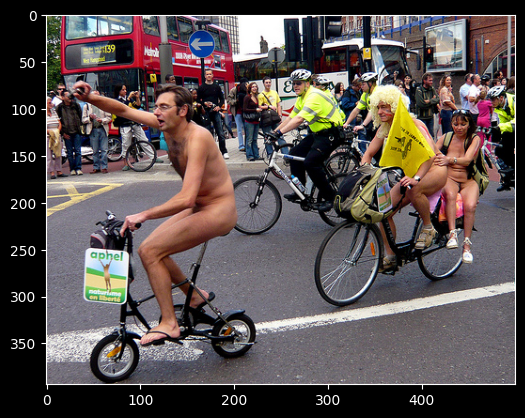


This image is unavailable in your country in compliance with local laws.

A brown dog and a black dog run into each other in the grass .


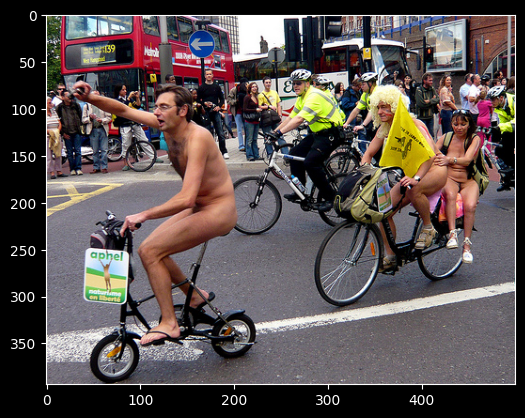


An Arabic man in a white hat .


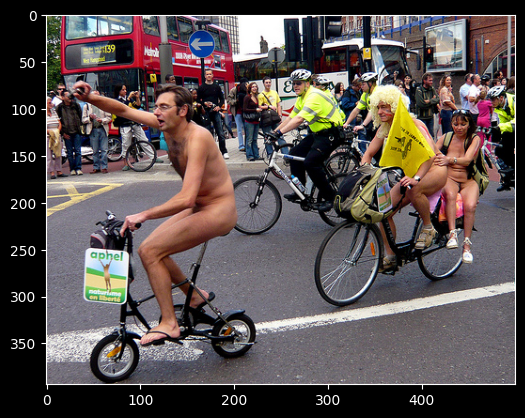


a kickboxer jumping for a kick


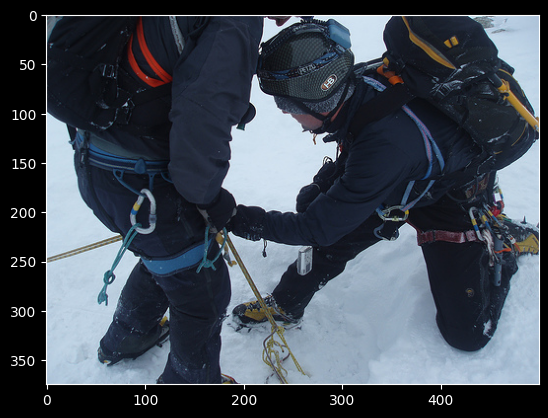


This image is unavailable in your country in compliance with local laws.

This image is unavailable in your country in compliance with local laws.

A little girl wearing a purple winter coat and sunglasses skiing in the snow .


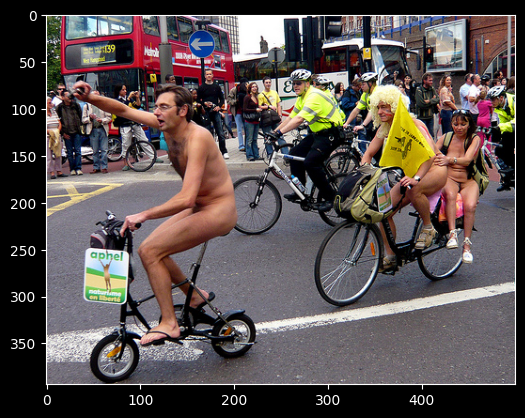


This image is unavailable in your country in compliance with local laws.

A little girl with purple hat is riding a tricycle along paved road by some farmland .


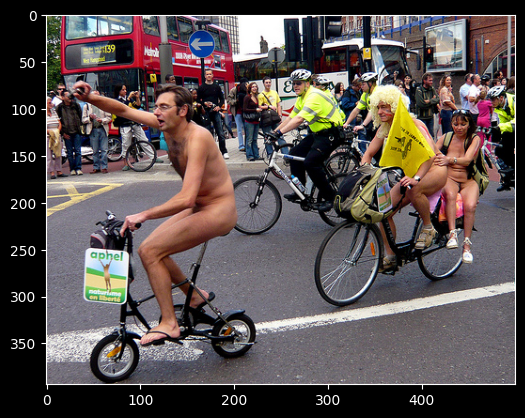

In [ ]:
for _ in range(10):
    query_ = test_queries['query_text'].iloc[np.random.randint(0, len(test_queries))]
    query_ = check(query_)
    if query_ != 'This image is unavailable in your country in compliance with local laws.':

        print(query_)

        id_ = test_queries.loc[test_queries['query_text'] == query_].index.tolist()
        test_query_ = test_data_.loc[id_[0], :].to_frame().T[[_ for _ in range(768)]]

        result_l = []
        id_image_l = []
        f = 0
        for id_image in range(len(test_files) + len(train_files)):
            f += 1
            if f < len(test_files):
                test_query_full = pd.merge(test_query_.reset_index(drop=True),
                                        pd.DataFrame(test_vectors_array[id_image]).T,
                                           left_index=True, right_index=True)

                test_query_full_nn = torch.FloatTensor(test_query_full.values).to(device)

                net.eval()
                with torch.no_grad():
                    preds = net.forward(test_query_full_nn).flatten().to(device)
                    result_l.append(preds.item())

            else:

                test_query_full = pd.merge(test_query_.reset_index(drop=True),
                                        pd.DataFrame(train_vectors_array[id_image-len(test_files)]).T,
                                           left_index=True, right_index=True)

                test_query_full_nn = torch.FloatTensor(test_query_full.values).to(device)

                net.eval()
                with torch.no_grad():
                    preds = net.forward(test_query_full_nn).flatten().to(device)
                    result_l.append(preds.item())


        best_result_ = max(result_l)
        best_id = result_l.index(best_result_)

        if best_id < len(test_files):
            directory = os.path.join(DATA_PATH, 'test_images')
            image_path = os.path.join(directory, train_files[best_id-len(test_files)])

            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.show()

        else:
            directory = os.path.join(DATA_PATH, 'train_images')
            image_path = os.path.join(directory, train_files[best_id-len(train_files)])

            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.show()
        print()
    else:
        print(query_)
        print()

In [ ]:
result_l[:10]

[0.28711217641830444,
 0.2912867069244385,
 0.27854087948799133,
 0.28727439045906067,
 0.2966062128543854,
 0.28096070885658264,
 0.27502840757369995,
 0.2720927596092224,
 0.28150689601898193,
 0.27720633149147034]

In [ ]:
test_data.head(2)

0         1         2         3         4         5         6     \
10 -0.125126 -0.258420 -0.593952 -0.098036 -0.016020 -0.171555  0.605907   
11 -0.457283  0.092233 -0.162494 -0.064760 -0.449362  0.248554  0.392306   

        7         8         9     ...      2806      2807     2808      2809  \
10  0.336303 -0.570111 -0.173514  ...  0.438391  0.415756  0.41072  0.406811   
11  1.070548 -0.787831  0.245317  ...  0.438391  0.415756  0.41072  0.406811   

        2810      2811      2812      2813      2814      2815  
10  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  
11  0.423006  0.173369  0.457793  0.317158  0.430947  0.346752  

[2 rows x 2816 columns]

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными

<h4>EDA:</h4>

-Фотографии находящиеся в директории выглядят +- корректно, у некоторых чуть меньший формат. Присутствуют изображения с несовершеннолетними

-Таблица train_df представляет тренировочную выборку в которой соответствие названия .jpg файла 'image' c фразой в колонке 'query_text'. Всего 5822 наблюдения, пропусков и явных дубликатов нет

-CrowdAnnotations имеет ценность оценки соответствия с краудсорсинга для различных изображений со фразами. Всего 47830 наблюдений, пропусков и явных дубликатов нет

-В ExpertAnnotations представленна оценнка 3 экспертов для данных из тренировочной выборки, оценка экспертов объединена в колонке 'general_rating'. Всего 5822 наблюдения, пропусков и явных дубликатов нет

-test_queries данные для тестирования с изображениями и описанием. 500 семплов, пропусков и явных дубликатов нет

-test_images колонка с именами .jpg файлов. 100 семплов, пропусков и явных дубликатов нет

<h4>Проверка данных</h4>

-Создана функция для проверки описания по запрещенным словам-триггерам отсылающих на детей до 16 лет. Отфильтрованы фреймы данной функцией

<h4>Векторизация изображений</h4>

-Проведена векторизация изображений в numpy массив при помощи предобученного алгоритма ResNet-50 на датасете ImageNet. Были отобранны только разрешенные фотографии

<h4>Векторизация текстов</h4>

-Проведено преобразование текста в массив векторов после его очистки и лемматизации при помощи токенизатора BERT

<h4>Объединение векторов</h4>

-Выполнено объединение данных полученных с векторизации изображения и текста. Тренировочная выборка - 1799 строк и 2099 колонок вкл. целевую переменную, тестовая выборка 320 строк 2098 колонок. Целевая переменная переведена в формат от 0 до 1 где где 0-это полностью не соответствует 1-полностью соответствует описание изображению

<h4>Обучение моделей</h4>

-Проведено разбиение выборки на тренировочную и валидационную, при помощи метода главных компонент сократили кол-во колонок на 2090 и оставили 8, что значительно повысило скорость обучения

-Обучена модель линейной регрессии, метрика RMSE на валидации: 0.20843574880898397

-Подобраны гиперпараметры и обучен алгоритм градиентного бустинга CatBoostRegressor, лучшие параметры:

['loss_function': 'RMSE', 'use_best_model': True, 'random_state': 42, 'learning_rate': 0.013665909398774875, 'n_estimators': 1123, 'max_depth': 5]

Метрика RMSE на кросс-валидации: 0.21047381880693014

-Обучен алгоритм нейронной сети с 2-мя скрытыми параметрами

['RMSE: 0.20689857941481618', 'Нейроны 1 слой: 450', 'Нейроны 2 слой: 350', 'Функ. акт. 1 слоя: ReLU()', 'Функ. акт. 2 слоя: ReLU()', 'learning rate: 0.01', 'Номер эпохи: 70', 'dropout 1 слоя: 0.2', 'dropout 2 слоя: 0.2', 'размер батча: 300', 'регуляризация l1: 0.001', 'регуляризация l2: 0']

который показал лучшее значение метрики и был обучен с лучшими параметрами на данных вкл. валидацию

<h4>Тестирование модели</h4>

-Написана функция check для проверки запроса на запрещенные по тегам слова, изображения используются только корректные

**Алгоритм работы демонстрационной модели:**

-Подаем 10 запросов из тестовой выборки случайным образом, проходим проверку запроса

-Все запросы в тестовой выборке у нас уже есть в виде эмбеддингов, связываемся с ними посредством общих id

-Собираем полный запрос прибавляя к нему эмбеддинг изображения по очереди перебирая их из доступных

-Каждую итерацию получаем предсказания соответствия от предобученной сети на эмбеддинге запроса и перебирая эмбеддинги изображений, сохраняя результат в лист

-Выбираем максимальное значение из списка, что нам говорит о том что к данному описанию лучше всего подошло изображение на котором был получен этот максимальный скор